## Este notebook contem análise exploratória de dados do crescimento do Covid-19 em Belo Horizonte e as diferenças com relação a Manaus.
### Período analisado: Março/2020 à Fevereiro/2021
### Fonte obtida em: https://covid.saude.gov.br/

In [1]:
#Importação das bibliotecas
import pandas as pd
import numpy as np
import seaborn as sns
import unicodedata
import re
import matplotlib.pyplot as plt

In [2]:
#Declaração de função para efetuar limpeza nas palavras, removendo números e caracteres especiais
def cleanWord(palavra, tipo='nome'):
  #Objetivo: Unicode normalize transforma um caracter em seu equivalente em latin.
  nfkd = unicodedata.normalize('NFKD', palavra)
  palavraSemAcento = u"".join([c for c in nfkd if not unicodedata.combining(c)])
  # Usa expressão regular para retornar a palavra apenas com números, letras e espaço
  if tipo == 'email':
    return re.sub('[^a-zA-Z0-9 \\\]', '', palavraSemAcento)
  else:
    return re.sub('[^a-zA-Z ]', '', palavraSemAcento)

In [3]:
#Importação da base de dados
df_covid19 = pd.read_csv('HIST_PAINEL_COVIDBR_05mar2021.csv', sep=';',error_bad_lines=False)
df_covid19.head()

,municipio,data,casosNovos,obitosNovos
0,Manaus,27/03/2020,0,0
1,Manaus,28/03/2020,105,0
2,Manaus,29/03/2020,26,0
3,Manaus,30/03/2020,9,0
4,Manaus,31/03/2020,19,2


In [4]:
#Tratamento do campo município
df_covid19 = df_covid19[df_covid19['municipio'].notna()]
df_covid19['municipio'] = df_covid19['municipio'].apply(cleanWord,args=('municipio',)).str.upper().str.strip()
df_covid19.head()

,municipio,data,casosNovos,obitosNovos
0,MANAUS,27/03/2020,0,0
1,MANAUS,28/03/2020,105,0
2,MANAUS,29/03/2020,26,0
3,MANAUS,30/03/2020,9,0
4,MANAUS,31/03/2020,19,2


In [5]:
df_covid19 = df_covid19[['municipio','data','casosNovos','obitosNovos']]
df_covid19.columns =['MUNICIPIO','DT_NOTIFIC','CASOS','OBITOS']

In [6]:
#Filtrando os dados dos municípios de BELO HORIZONTE e MANAUS
filtro = (df_covid19['MUNICIPIO'] == 'BELO HORIZONTE') | (df_covid19['MUNICIPIO'] == 'MANAUS')
df_covid19 = df_covid19.loc[filtro, :]
df_covid19.head()

,MUNICIPIO,DT_NOTIFIC,CASOS,OBITOS
0,MANAUS,27/03/2020,0,0
1,MANAUS,28/03/2020,105,0
2,MANAUS,29/03/2020,26,0
3,MANAUS,30/03/2020,9,0
4,MANAUS,31/03/2020,19,2


In [7]:
#Filtrando período de março de 2020 até fevereiro de 2021
df_covid19['PERIODO'] = pd.to_datetime(df_covid19['DT_NOTIFIC']).dt.to_period('M') 

filtro2 = (df_covid19['PERIODO'] > '2020-02') & (df_covid19['PERIODO'] < '2021-3')
df_covid19 = df_covid19.loc[filtro2, :]

df_covid19.head()

,MUNICIPIO,DT_NOTIFIC,CASOS,OBITOS,PERIODO
0,MANAUS,27/03/2020,0,0,2020-03
1,MANAUS,28/03/2020,105,0,2020-03
2,MANAUS,29/03/2020,26,0,2020-03
3,MANAUS,30/03/2020,9,0,2020-03
4,MANAUS,31/03/2020,19,2,2020-03


In [8]:
#Separando as bases - BH e Manaus
df_covid19_BH = df_covid19.loc[df_covid19['MUNICIPIO'] == 'BELO HORIZONTE', :]
df_covid19_MA = df_covid19.loc[df_covid19['MUNICIPIO'] == 'MANAUS', :]

In [9]:
#Transformando os municípios em colunas
df_final = df_covid19_MA.merge(df_covid19_BH, how='inner',on='DT_NOTIFIC')
df_final = df_final.drop(['DT_NOTIFIC','PERIODO_y'], 1)
df_final.columns=['MUNICIPIO_MA','CASOS MANAUS','OBITOS MANAUS','PERIODO','MUNICIPIO_BH','CASOS BH','OBITOS BH'] 
df_final.head()

,MUNICIPIO_MA,CASOS MANAUS,OBITOS MANAUS,PERIODO,MUNICIPIO_BH,CASOS BH,OBITOS BH
0,MANAUS,0,0,2020-03,BELO HORIZONTE,0,0
1,MANAUS,105,0,2020-03,BELO HORIZONTE,129,0
2,MANAUS,26,0,2020-03,BELO HORIZONTE,14,0
3,MANAUS,9,0,2020-03,BELO HORIZONTE,20,1
4,MANAUS,19,2,2020-03,BELO HORIZONTE,0,1


In [10]:
#Agregando informações
df_final = df_final.assign(   
    MUNICIPIO_MA=df_final['MUNICIPIO_MA'],
    CASOS_MA=df_final['CASOS MANAUS'],
    OBITOS_MANAUS=df_final['OBITOS MANAUS'],
    PERIODO=df_final['PERIODO'],
    MUNICIPIO_BH=df_final['MUNICIPIO_BH'],
    CASOS_BH=df_final['CASOS BH'],
    OBITOS_BH=df_final['OBITOS BH']
).groupby(['MUNICIPIO_MA','PERIODO','MUNICIPIO_BH']).agg({'CASOS MANAUS': 'sum','CASOS BH': 'sum','OBITOS MANAUS':'sum','OBITOS BH':'sum'}).reset_index()

df_covid19_BH = df_covid19_BH.assign(   
    MUNICIPIO=df_covid19_BH['MUNICIPIO'],
    PERIODO=df_covid19_BH['PERIODO'],
    CASOS=df_covid19_BH['CASOS'],
    OBTOS=df_covid19_BH['OBITOS']
).groupby(['MUNICIPIO','PERIODO']).agg({'CASOS': 'sum','OBITOS':'sum'}).reset_index()

df_covid19_MA = df_covid19_MA.assign(   
    MUNICIPIO=df_covid19_MA['MUNICIPIO'],
    PERIODO=df_covid19_MA['PERIODO'],
    CASOS=df_covid19_MA['CASOS'],
    OBITOS=df_covid19_MA['OBITOS']
).groupby(['MUNICIPIO','PERIODO']).agg({'CASOS': 'sum','OBITOS':'sum'}).reset_index()

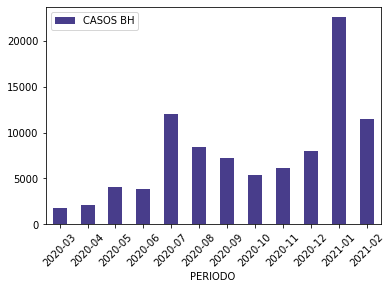

In [11]:
#Plotando gráfico de barras dos casos de BH

df=df_covid19_BH[['PERIODO','CASOS']]

df.columns =['PERIODO','CASOS BH']

df = df.set_index('PERIODO')

df.plot.bar(color='darkslateblue', rot=45)
plt.show();

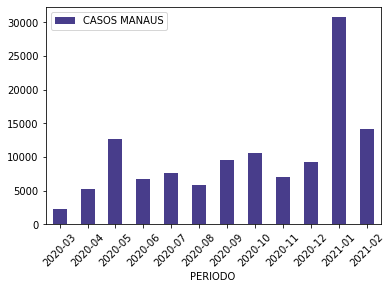

In [12]:
#Plotando gráfico de barras dos casos de Manaus

df=df_covid19_MA[['PERIODO','CASOS']]

df.columns =['PERIODO','CASOS MANAUS']

df = df.set_index('PERIODO')

df.plot.bar(color='darkslateblue', rot=45)
plt.show();

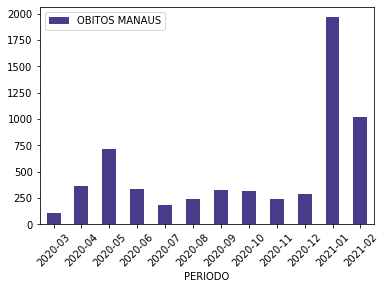

In [13]:
#Plotando gráfico de barras dos óbitos de Manaus

df=df_covid19_MA[['PERIODO','OBITOS']]

df.columns =['PERIODO','OBITOS MANAUS']

df = df.set_index('PERIODO')

df.plot.bar(color='darkslateblue', rot=45)
plt.show();

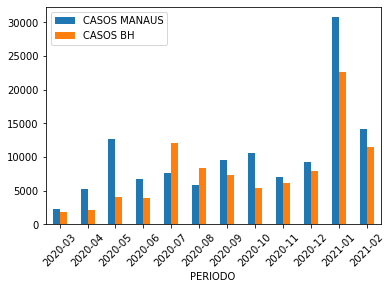

In [14]:
#Plotando gráfico de barras comparativo de casos de BH x Manaus

df=df_final[['PERIODO','CASOS MANAUS','CASOS BH']]

df = df.set_index('PERIODO')

df.plot.bar( rot=45)
plt.show();

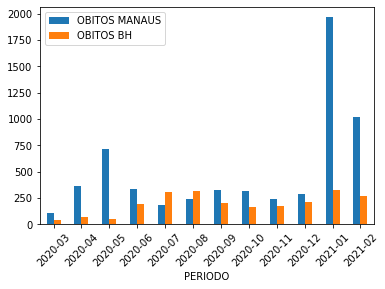

In [15]:
#Plotando gráfico de barras comparativo de óbitos de BH x Manaus

df=df_final[['PERIODO','OBITOS MANAUS','OBITOS BH']]

df = df.set_index('PERIODO')

df.plot.bar( rot=45)
plt.show();

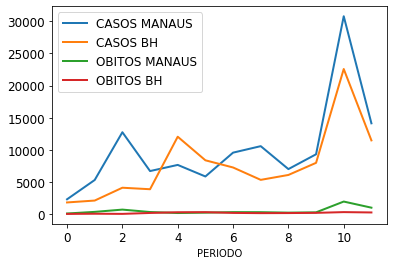

In [16]:
#Gráfico comparativo de casos x óbitos
ax = df_final.plot(linewidth=2, fontsize=12);

ax.set_xlabel('PERIODO'); 
 
ax.legend(fontsize=12);

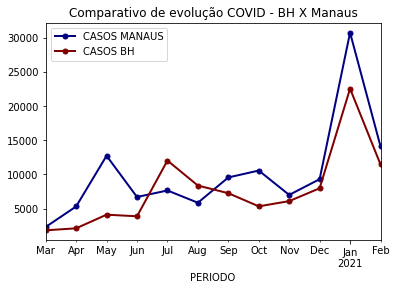

In [17]:
#Plotando gráfico de linhas comparativo de casos de BH x Manaus

df_casos = df_final[['MUNICIPIO_MA','PERIODO','CASOS MANAUS','MUNICIPIO_BH','CASOS BH']]

df = df_casos.set_index('PERIODO')

df.plot(lw=2, colormap='jet', marker='.', markersize=10, 
         title='Comparativo de evolução COVID - BH X Manaus')

In [18]:
#incidência de casos por Estado, a cada 100 mil
populacao=df_casos.copy()
populacao_BH = 2512070
populacao_MA = 2219580
populacao['BELO HORIZONTE'] = (populacao['CASOS BH']/populacao_BH)*100000
populacao['MANAUS'] = (populacao['CASOS MANAUS']/populacao_MA)*100000
populacao.head()

,MUNICIPIO_MA,PERIODO,CASOS MANAUS,MUNICIPIO_BH,CASOS BH,BELO HORIZONTE,MANAUS
0,MANAUS,2020-03,2316,BELO HORIZONTE,1826,72.689057,104.344065
1,MANAUS,2020-04,5317,BELO HORIZONTE,2121,84.432361,239.549825
2,MANAUS,2020-05,12738,BELO HORIZONTE,4114,163.769322,573.892358
3,MANAUS,2020-06,6704,BELO HORIZONTE,3881,154.494102,302.039125
4,MANAUS,2020-07,7659,BELO HORIZONTE,12041,479.325815,345.065283


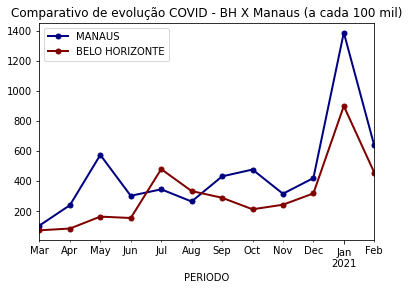

In [19]:
#Plotando gráfico de linhas comparativo de casos de BH x Manaus a cada 100 mil habitantes
df = populacao[['MUNICIPIO_MA','PERIODO','MANAUS','MUNICIPIO_BH','BELO HORIZONTE']]
df = df.set_index('PERIODO')

df.plot(lw=2, colormap='jet', marker='.', markersize=10, 
         title='Comparativo de evolução COVID - BH X Manaus (a cada 100 mil)')

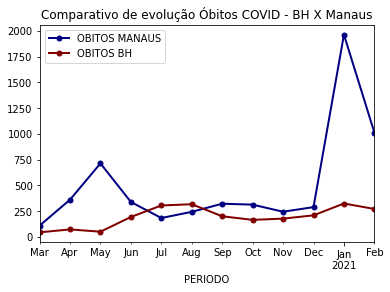

In [20]:
#Comparativo de óbitos
df_obitos = df_final[['MUNICIPIO_MA','PERIODO','OBITOS MANAUS','MUNICIPIO_BH','OBITOS BH']]

df = df_obitos.set_index('PERIODO')

df.plot(lw=2, colormap='jet', marker='.', markersize=10, 
         title='Comparativo de evolução Óbitos COVID - BH X Manaus')

In [22]:
# Percentual de casos/obitos em Manaus 
df_covid19_MA['% CASOS'] = ((df_covid19_MA['CASOS']*100)/populacao_MA)
df_covid19_MA['% MORTALIDADE'] = ((df_covid19_MA['OBITOS']*100)/df_covid19_MA['CASOS'])
df_covid19_MA

,MUNICIPIO,PERIODO,CASOS,OBITOS,% POPULAÇÃO,% MORTALIDADE,% CASOS
0,MANAUS,2020-03,2316,109,0.104344,4.706390,0.104344
1,MANAUS,2020-04,5317,361,0.239550,6.789543,0.239550
2,MANAUS,2020-05,12738,714,0.573892,5.605276,0.573892
3,MANAUS,2020-06,6704,339,0.302039,5.056683,0.302039
4,MANAUS,2020-07,7659,183,0.345065,2.389346,0.345065
5,MANAUS,2020-08,5863,243,0.264149,4.144636,0.264149
6,MANAUS,2020-09,9566,322,0.430982,3.366088,0.430982
7,MANAUS,2020-10,10575,313,0.476441,2.959811,0.476441
8,MANAUS,2020-11,7010,244,0.315826,3.480742,0.315826
9,MANAUS,2020-12,9312,289,0.419539,3.103522,0.419539
